In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from sentinelhub import SentinelHubRequest, DataCollection, MimeType, CRS, BBox, SHConfig
from dotenv import load_dotenv
from pyproj import Transformer
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import folium
import cv2
from urban_watch.ml_logic.data import load_data
from s2cloudless import S2PixelCloudDetector
from urban_watch.ml_logic.package import CloudMasker
from urban_watch.ml_logic.package import preprocess_image

In [2]:
from sentinelhub import SHConfig
from dotenv import load_dotenv
import os

In [3]:
load_dotenv()  # charge automatiquement le .env du dossier courant

config = SHConfig()
config.sh_client_id = os.environ.get("SH_CLIENT_ID")
config.sh_client_secret = os.environ.get("SH_CLIENT_SECRET")

In [4]:
list_bbox_centers = [(43.52960344286241, 5.448962145567533),
(48.092094070852475, -1.7036876101196967),
 (48.121222106840435, -1.602864906604979),
 (45.74557103359813, 4.803091960652229),
 (47.8776770361181, -3.909947991759771),
 (44.55378060775165, 4.28389205759154),
 (45.69764498502806, 5.8945655967385315),
 (48.07500134978729, 7.3491231648955155),
 (50.63412206750312, 3.0435779303880106),
 (44.83078182200822, 0.5108123933396876)]

In [5]:
from urban_watch.ml_logic.data import make_bbox_global, get_data

data = get_data(list_bbox_centers, config)

📡 Downloading tile 0 at 43.52960344286241,5.448962145567533 ...
✔ Saved tile 0 in /Users/clairedebadts/code/augustinlafond/project_urban_watch/raw_data/tile_0
📡 Downloading tile 1 at 48.092094070852475,-1.7036876101196967 ...
✔ Saved tile 1 in /Users/clairedebadts/code/augustinlafond/project_urban_watch/raw_data/tile_1
📡 Downloading tile 2 at 48.121222106840435,-1.602864906604979 ...
✔ Saved tile 2 in /Users/clairedebadts/code/augustinlafond/project_urban_watch/raw_data/tile_2
📡 Downloading tile 3 at 45.74557103359813,4.803091960652229 ...
✔ Saved tile 3 in /Users/clairedebadts/code/augustinlafond/project_urban_watch/raw_data/tile_3
📡 Downloading tile 4 at 47.8776770361181,-3.909947991759771 ...
✔ Saved tile 4 in /Users/clairedebadts/code/augustinlafond/project_urban_watch/raw_data/tile_4
📡 Downloading tile 5 at 44.55378060775165,4.28389205759154 ...
✔ Saved tile 5 in /Users/clairedebadts/code/augustinlafond/project_urban_watch/raw_data/tile_5
📡 Downloading tile 6 at 45.69764498502806,

In [6]:
from urban_watch.ml_logic.data import load_data

X, meta = load_data()
print("shape de x:", X.shape)
print("Nombre de NaN dans X brut :", np.isnan(X).sum())

shape de x: (10, 300, 300, 10)
Nombre de NaN dans X brut : 0


In [7]:
from urban_watch.ml_logic.labels import get_bbox_from_features, bbox_to_wgs84

list_bbox, list_crs = get_bbox_from_features()
list_bbox_wgs84 = bbox_to_wgs84(list_bbox, list_crs)

/Users/clairedebadts/.pyenv/versions/urban_watch/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.6) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [8]:
from urban_watch.ml_logic.labels import tile_name_from_bbox_wgs84

tile_names = tile_name_from_bbox_wgs84(list_bbox_wgs84)

In [9]:
from urban_watch.ml_logic.labels import get_label_array

results = get_label_array(tile_names, list_bbox_wgs84, list_bbox, list_crs)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Exemple palette simplifiée
colors = [
    "#006400",  # 10 Trees
    "#ffbb22",  # 20 Shrub
    "#ffff4c",  # 30 Grass
    "#f096ff",  # 40 Crop
    "#fa0000",  # 50 Built-up
    "#b4b4b4",  # 60 Bare
    "#f0f0f0",  # 70 Snow
    "#0064c8",  # 80 Water
    "#0096a0",  # 90 Wetlands
    "#00cf75",  # 95 Mangroves
    "#fae6a0"   # 100 Moss/Lichen
]

cmap = ListedColormap(colors)


In [11]:
image = X[6,:,:,:]

B2, B3, B4, B8, B11 = image[:,:,0], image[:,:,1], image[:,:,2], image[:,:,3], image[:,:,4]

# True color (attention : nécessite une normalisation)
RGB = np.dstack([
    B4,
    B3,
    B2
]).astype(float)

# Normalisation 0-1 pour affichage (important !)
RGB = (RGB - RGB.min()) / (RGB.max() - RGB.min() + 1e-6)

# Normalisation par percentiles (évite que quelques pixels lumineux écrasent tout le contraste)
p2 = np.percentile(RGB, 2)
p98 = np.percentile(RGB, 98)

RGB_stretched = np.clip((RGB - p2) / (p98 - p2), 0, 1)

# Correction gamma (0.7–1.0 recommandé)
gamma = 0.8
RGB_corrected = np.clip(RGB_stretched ** gamma, 0, 1)


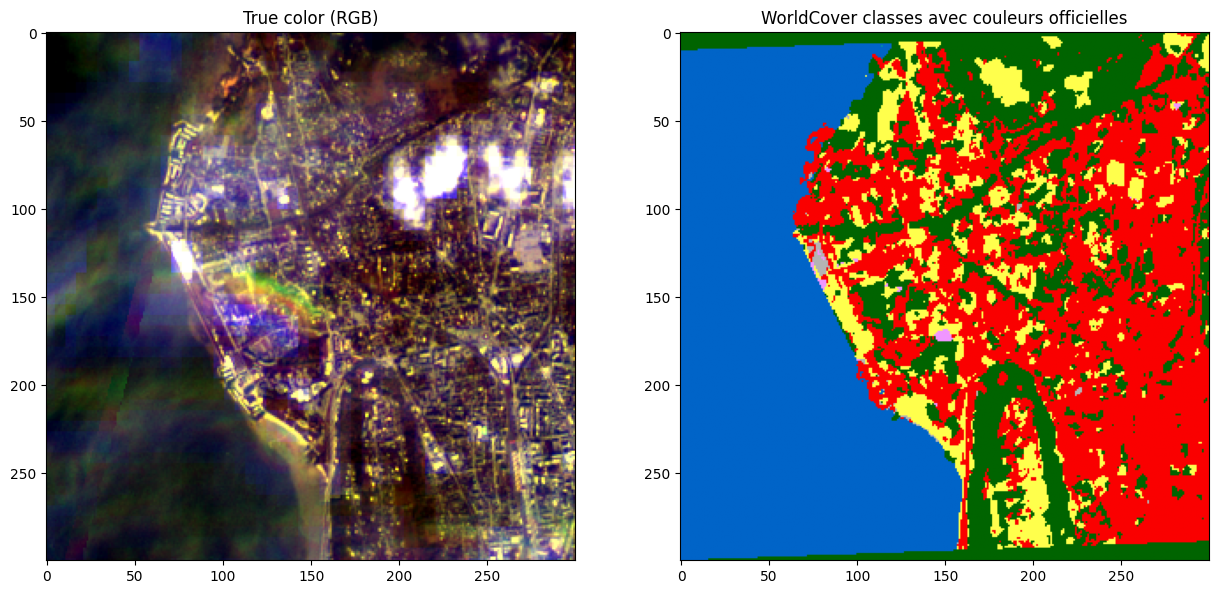

In [13]:
plt.figure(figsize=(15, 7))

plt.subplot(1,2,1)
plt.imshow(RGB_stretched)
plt.title("True color (RGB)")

plt.subplot(1,2,2)
plt.imshow(results[6], cmap=cmap, vmin=10, vmax=110)
plt.title("WorldCover classes avec couleurs officielles")
plt.show()


debut du test train model avec le Y


In [12]:
y_list =results

In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import time

In [14]:
y = np.array(y_list)

print("Labels uniques :", np.unique(y))
print("Shape y:", y.shape)

Labels uniques : [ 0 10 20 30 40 50 60 80 90]
Shape y: (10, 300, 300)


In [15]:
X_list = []
y_list = []
for i in range(X.shape[0]):
    img = X[i]
    label = y[i]

    X_processed, mask_valid= preprocess_image(img)

    y_flat = label.reshape(-1)
    y_valid = y_flat[mask_valid.reshape(-1)]

    X_list.append(X_processed)
    y_list.append(y_valid)

X_all = np.vstack(X_list)
y_all = np.hstack(y_list)

print("X_all", X_all.shape)
print("y_all", y_all.shape)
print("nan dans xall", np.isnan(X_all).sum())


X_all (648654, 13)
y_all (648654,)
nan dans xall 0


In [16]:
y_binary = (y_all == 50).astype(int)

In [17]:
non_urbain_count = (y_binary == 0).sum()
urbain_count = (y_binary == 1).sum()
print(f"  Non-urbain: {non_urbain_count} ({100*non_urbain_count/(non_urbain_count+urbain_count):.1f}%)")
print(f"  Urbain: {urbain_count} ({100*urbain_count/(non_urbain_count+urbain_count):.1f}%)")


  Non-urbain: 397690 (61.3%)
  Urbain: 250964 (38.7%)


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

In [25]:
print(f"Train set: {X_train.shape} | Test set: {X_test.shape}")

Train set: (518923, 13) | Test set: (129731, 13)


In [26]:
print("nan dans xall", np.isnan(X_all).sum())

nan dans xall 0


In [19]:
# Logistic regression

results ={}

param_logreg = {
    "C": [0.1, 1.0, 10.0],
    "penalty": ["l2"],
    "solver": ["lbfgs"],
    "max_iter": [500]
}

logreg = GridSearchCV(
    LogisticRegression(class_weight="balanced"),
    param_logreg,
    scoring="f1",
    cv=3,
    n_jobs=-1
    )

logreg.fit(X_train, y_train)

results["logreg"] = {
    "model": logreg.best_estimator_,
    "f1": f1_score(y_test, logreg.predict(X_test))
}

In [20]:
results

{'logreg': {'model': LogisticRegression(class_weight='balanced', max_iter=500),
  'f1': 0.6860253412567119}}

In [24]:
# Random Forest

param_rf = {
    "n_estimators": [50],
    "max_depth": [12],
    "min_samples_leaf": [5],
    "class_weight": ["balanced"]
}

rf = GridSearchCV(
    RandomForestClassifier(n_jobs=-1, random_state=42),
    param_rf,
    scoring="f1",
    cv=3,
    n_jobs=-1
)

rf.fit(X_train, y_train)

results["rf"] = {
    "model": rf.best_estimator_,
    "f1": f1_score(y_test, rf.predict(X_test))
}

In [25]:
results

{'logreg': {'model': LogisticRegression(class_weight='balanced', max_iter=500),
  'f1': 0.6860253412567119},
 'hgb': {'model': HistGradientBoostingClassifier(max_depth=16, max_leaf_nodes=63, random_state=42),
  'f1': 0.7717060032603302},
 'rf': {'model': RandomForestClassifier(class_weight='balanced', max_depth=12,
                         min_samples_leaf=5, n_estimators=50, n_jobs=-1,
                         random_state=42),
  'f1': 0.7635838150289017}}

In [26]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [ ]:
param_rf1 = {
    "n_estimators": randint(50, 300),
    "max_depth": randint(5, 25),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10),
    "max_features": ["sqrt", "log2", None],
}

rf1_search = RandomizedSearchCV(
    RandomForestClassifier(class_weight="balanced"),
    param_distributions=param_rf1,
    n_iter=20,        # try 20 iterations → strong results under 1–2 minutes
    scoring="f1",
    cv=3,
    n_jobs=-1,
    random_state=42
)
rf1_search.fit(X_train, y_train)
results["rf"] = {
    "best_model": rf1_search.best_estimator_,
    "f1": f1_score(y_test, rf_search.predict(X_test)),
    "report": classification_report(y_test, rf_search.predict(X_test))
}

In [22]:
# History Gradient Boosting Classifier

param_hgb = {
    "learning_rate": [0.05, 0.1],
    "max_depth": [8, 12, 16],
    "max_leaf_nodes": [31, 63]
}

hgb = GridSearchCV(
    HistGradientBoostingClassifier(random_state=42),
    param_hgb,
    scoring="f1",
    cv=3,
    n_jobs=-1
)

hgb.fit(X_train, y_train)

results["hgb"] = {
    "model": hgb.best_estimator_,
    "f1": f1_score(y_test, hgb.predict(X_test))
}

In [23]:
results

{'logreg': {'model': LogisticRegression(class_weight='balanced', max_iter=500),
  'f1': 0.6860253412567119},
 'hgb': {'model': HistGradientBoostingClassifier(max_depth=16, max_leaf_nodes=63, random_state=42),
  'f1': 0.7717060032603302}}

In [ ]:
results["hgb"]

In [ ]:
best_name = max(results, key=lambda k: results[k]["f1"])
best_model = results[best_name]["model"]

print("\n==== Model performances ====")
for name, res in results.items():
    print(f"{name}: f1={res['f1']:.4f}")

print(f"\n🏆 Best model: {best_name.upper()} (f1={results[best_name]['f1']:.4f})")


In [ ]:
def save_model(model, path="urban_watch_model.joblib"):
    joblib.dump(model, path)
    print(f"Model saved at {path}")

CODE KEVIN ....

In [ ]:
clf = RandomForestClassifier(n_estimators=100,
                             max_depth=20,
                             random_state=42,
                             n_jobs=-1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

Accuracy: 0.8490954359405231
F1-score: 0.8021586005477348


In [25]:
train_pred = clf.predict(X_train)
from sklearn.metrics import accuracy_score
print("Train Accuracy:", accuracy_score(y_train, train_pred))

Train Accuracy: 0.9569570051818863


In [26]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,          # limite la profondeur
    min_samples_leaf=5,    # évite les feuilles trop petites
    class_weight="balanced",
    random_state=42
)
clf.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [27]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')
print("CV F1-score:", scores.mean())


CV F1-score: 0.784489582800278
